> Pharmacokinetic Analysis

Ref: [Winnonlin Guide 8.3](https://onlinehelp.certara.com/phoenix/8.3/responsive_html5_!MasterPage!/WinNonlin%20User%27s%20Guide.pdf), [Design and Analysis of Bioavailability and Bioequivalence Studies](ttps://books.google.co.kr/books?hl=ko&lr=&id=KtKJFGJeV3MC&oi=fnd&pg=PP1&dq=Design+and+analysis+of+bioavailability+and+bioequivalence+studies+,+Third+edition,+Chapman+%26+Hall&ots=scXq3Y2TPA&sig=S_FTX9fEmubxjz2RlouUnbWL7f0#v=onepage&q=Design%20and%20analysis%20of%20bioavailability%20and%20bioequivalence%20studies%20%2C%20Third%20edition%2C%20Chapman%20%26%20Hall&f=false), [2×k 교차설계법에서
생물학적 동등성 추가시험의 통계적 절
†](http://koreascience.or.kr/article/JAKO201436351074280.pf)d, [식품의약품안전처 의약품 동등성 시험 기준](https://www.law.go.kr/LSW/admRulLsInfoP.do?admRulSeq=2100000129149)

# Import

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz # AUC
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import copy
import statsmodels.api as sm
import statsmodels.formula.api as smf

# PK Analysis

## Generic Medicine

- a generic medicine works in the same way and provides the same clinical benefit as the brand-name medicine.^[https://www.fda.gov/drugs/frequently-asked-questions-popular-topics/generic-drugs-questions-answers]

- 특허기간이 만료된 오리지널 의약품과 주성분, 함량 및 제형이 동일하게 복제된 제네릭 의약품은 생
물학적 동등성 (이하‘생동성’이라 한다)시험을 통해 오리지널 의약품과 약효가 동등하다는 것을 입증 
면 시장에 진입할 수 있다.^[http://koreascience.or.kr/article/JAKO201436351074280.df]d

- 제네릭 의약품을 승인 받기 위해 생동성 시험을 거쳐야 한다]

## Bioequivalent

- Drug companies must submit an abbreviated new drug application (ANDA) to FDA for approval to market a generic drug that is the same as (or bioequivalent to) the brand product^[https://www.fda.gov/drugs/frequently-asked-questions-popular-topics/generic-drugs-questions-answers]

- 생동성 시험은 제재학적으로 동등한 두 제제의 동등성 입증을 위해 실시하는 샐체내 실험으로, 통계학적으로 두 제제의 생체이용률의 유사성을 비교하는 시험을 의미한다.^[http://koreascience.or.kr/article/JAKO201436351074280.pdf]

## Parameter

- $AUC_t$
    - Area under the curve from the time of dosing to the time of the last measurable (positive) 
concentratio
    - 약물 투여 시점부터 마지막으로 측정 가능한 (양수인) 농도까지의 면적인 (Area Under the Curve, AUC)는 약동학에서 사용되는 일반적인 파라미터
    - 시간에 따른 약물 노출의 범위를 추정하는 데 사용
    - 해당 기간 동안 혈중에서의 누적된 약물 농도를 나타냄

 - $C_{max}$    -  Maximum observed concentration, occurring at time Tmax, as defined above.
    -  $T_{max}$에서의 최대 농도
 - $T_{max}$
    - Time of maximum observed concentration. For non-steady-state data, the entire curve is considered. If the maximum observed concentration is not unique, then the first maximum is used.
    - 최대 혈중 농도가 관찰된 시간
    - 유일한 값이 아닌 경우 첫번재 값 사용
 
- $\lambda_z$
    - First-order rate constant associated with the terminal (log-linear) portion of the curve. 
Estimated by linear regression of time vs. log concentration
    - 곡선의 말단(로그-선형) 부분과 관련된 1차 속도상수는 시간 대 로그 농도의 선형 회귀를 통해 추정
    - 곡선의 로그-선형 영역에서 시간과 로그 농도 간의 선형 관계를 분석하여 얻어진 1차 속도상수
    - 약동학 데이터의 로그-선형 부분에서 시간 대 로그 농도의 관계를 선형 회귀하여 추정된 1차 속도상수를 의미.
- $ln(2)/\lambda_z$
    -  Terminal half-life

- $Tau$
    -  Available in the Dosing Used results worksheet for steady-state data. The (assumed equal) dosing interval for steady-state data.
    -  반복 투여하는 연구에서 반복투여하는 간격
    -  예) 12시간 간격으로 하루에 두 번 투여시, tau = 12

- $AUC_{TAU}$
    - The partial area from dosing time to dosing time plus Tau. See “Partial area calculation”
    - for information on how it is computed
    - tau간격 별로 혈중 농도 곡선 하 면적.

-$\text{ Swing}$: Cmax – Cmn/Cmin

-$\text{ Fluctuation}$ 

- 100(Cmax – Cmin)/Cavg
-  where Cmin and Cmax were obtained between dosing time and dosing time plus Tau
- 약물 농도의 최소값($C_{min}$)과 최대값($C_{max}$) 사이의 변동을 약물 투여 간격 내에서 평균 농도($C_{avg}$)에 대한 백분율로 나타내는 약동학적 파라미터 .



약동학 파라메터 산출 프로그램 윈놀린 가이드 참고^[https://onlinehelp.certara.com/phoenix/8.3/responsive_html5_!MasterPage!/WinNonlin%20User%27s%20Guide.pdf]

- page 146 정도부터 파라메터 설명 및 계산법 확인

아래는 식품의약품 안전처 규칙 내용 중 일부

AUCt: 투약시간부터 최종 혈중농도 정량 시간 t까지의 혈중농도-시간곡선하면적


AUC∞ : 투약시간부터 무한시간까지의 혈중농도-시간곡선하면적 (AUC∞ = AUCt + Ct/λZ


Ct : 최종정- 
도
λZ : 말단 소실 
- 
정수
AUCt/AUC∞ : AUCt의 AUC대
- 
한 비
t1/2β : 소실
- 
 반감기
AUCτ : 정상상태의 투여간격τ중의 혈-시간
- 
곡선하면적
x : 
- 
최고혈중농도
Css,max정상상태의
- 
 최고혈중농도
Css,m: 정상상태
- 
의 최저혈중농도 ax : 최고
- 
혈중농도 간
Umax 
- 
: 최대뇨중배설속도
Aet최종 채뇨시간 t
- 
까지의 뇨중누적배설량
Aeτ : 정상상태의 투여간 τ중의 뇨중누적배설량  가능

**동등성 기준 : Tmax를 제외한 대조약과 시험약의 비교평가항목치를 로그변환하여 통계처리 하였을 때, 로그변환한 평균치 차의 90% 신뢰구간이 log 0.8에서 log 1.25 이내이어야 한다**

## 2 x 2 Crossover Design

현재 식품의약품 안전처에서는 두 제제의 생동성 평가 방법으로 2 x 2 교차설계법을 이용하여 두 제제의 생체이용률의 평균을 비교하는 방법 사용

|    | Period 1 | Period 2  |
|:----:|:----------:|:-----------:|
|Sequence 1| Reference|Test|
|Sequence 2|Test|Reference|

$$y_{jkl} = \mu + g_j + S_{l(j)} + p_k + \pi_{jk} + \epsilon_{jkl}$$

$$j = 1,2; k = 1,2; l=1,2, \dots, n_{1j}$$

$$S_{l(j)} \sim iid N(0,\sigma^2_s) , \epsilon_{jkl} \sim iid N(0, \sigma^2_\epsilon)$$

### 혈중 농도 곡선 예시

In [178]:
_seq = ['1'] * 18 + ['2'] * 18
random.shuffle(_seq)

In [179]:
seq = _seq.copy()

In [180]:
prd = ['1', '2']

In [181]:
# Define the two-compartment model function
def two_compartment_model(t, ka, ke, Vc, Vp, dose):
    Cp = dose / (Vc + Vp) * (ka / (ka - ke)) * (np.exp(-ke * t) - np.exp(-ka * t))
    return Cp

In [182]:
# Time range
t = np.linspace(0, 24, 20)  # Generate 100 time points from 0 to 24 hours

In [183]:
# Number of subjects
n_subjects = 36

In [184]:
# Subject-specific pharmacokinetic parameter values
ka_values = np.random.uniform(0.2, 0.8, n_subjects)   # Elimination rate constant (1/hour)
ke_values = np.random.uniform(0.05, 0.15, n_subjects)  # Absorption rate constant (1/hour)
Vc_values = np.random.uniform(8, 12, n_subjects)      # Central volume of distribution (L)
Vp_values = np.random.uniform(3, 7, n_subjects)       # Peripheral volume of distribution (L)
dose = 100  # Dose (mg)

Conc1=[]
# Calculate and plot the pharmacokinetic concentration profile for each subject
for i in range(n_subjects):
    ka = ka_values[i]
    ke = ke_values[i]
    Vc = Vc_values[i]
    Vp = Vp_values[i]
    Sequence=seq[i]
    period = prd[0]
    Cp = two_compartment_model(t, ka, ke, Vc, Vp, dose)
    Conc1.append(Cp)

In [185]:
# Subject-specific pharmacokinetic parameter values
ka_values = np.random.uniform(0.2, 0.8, n_subjects)   # Elimination rate constant (1/hour)
ke_values = np.random.uniform(0.05, 0.15, n_subjects)  # Absorption rate constant (1/hour)
Vc_values = np.random.uniform(8, 12, n_subjects)      # Central volume of distribution (L)
Vp_values = np.random.uniform(3, 7, n_subjects)       # Peripheral volume of distribution (L)
dose = 100  # Dose (mg)

Conc2=[]
# Calculate and plot the pharmacokinetic concentration profile for each subject
for i in range(n_subjects):
    ka = ka_values[i]
    ke = ke_values[i]
    Vc = Vc_values[i]
    Vp = Vp_values[i]
    Sequence=seq[i]
    period = prd[1]
    Cp = two_compartment_model(t, ka, ke, Vc, Vp, dose)
    Conc2.append(Cp)

Text(0, 0.5, 'Concentration (mg/L)')

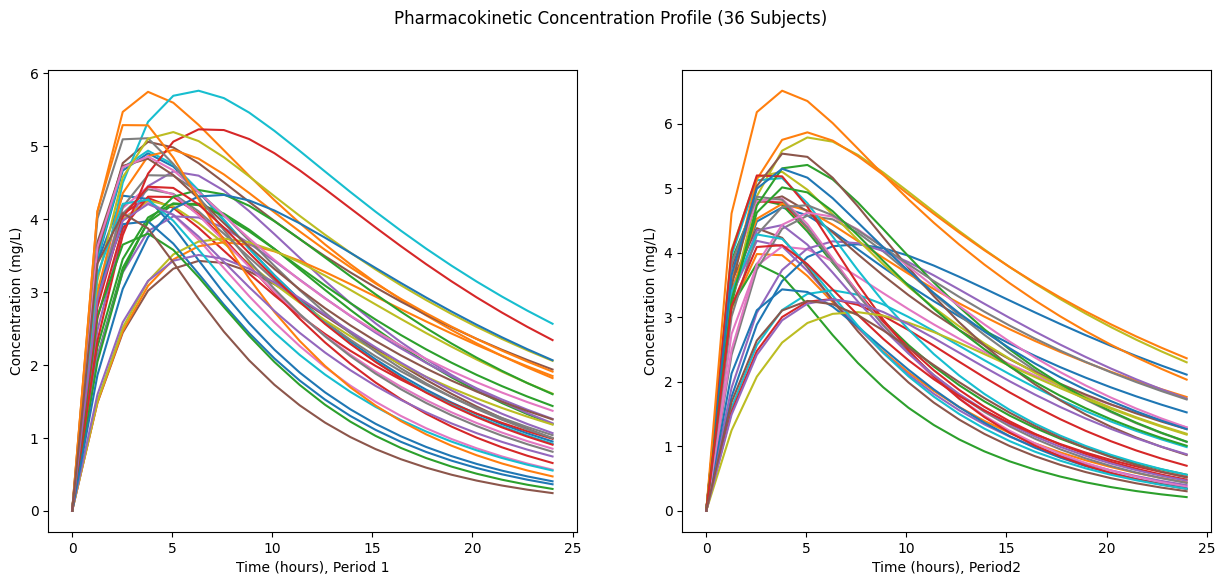

In [186]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Pharmacokinetic Concentration Profile (36 Subjects)')
for i in range(n_subjects):
    ax1.plot(t,Conc1[i])
    ax2.plot(t,Conc2[i])
ax1.set_xlabel('Time (hours), Period 1')
ax1.set_ylabel('Concentration (mg/L)')
ax2.set_xlabel('Time (hours), Period2')
ax2.set_ylabel('Concentration (mg/L)')

사다리꼴 공식으로 AUC 계산

In [187]:
auc=[]
# AUC 계산
for i in range(n_subjects):
    auc.append(trapz(Conc1, t))

auc[1]

array([ 65.48305637,  87.70558202,  65.77279922,  59.94537394,
        70.32030545,  54.830946  ,  52.00339   ,  62.81545225,
        62.93439762,  65.30458169,  47.62114112,  66.71389266,
        68.1867998 ,  56.77251002,  64.09797772,  82.141763  ,
        59.82448205,  65.18336814,  65.27591651, 100.33765543,
        44.22544578,  81.59585084,  73.20916947,  91.99372264,
        56.22611766,  69.04274613,  71.32365628,  63.94443322,
        86.26100397,  51.10227925,  77.43600209,  58.37683203,
        41.9120698 ,  61.92932377,  55.13465117,  39.61787006])

In [188]:
auc=[]
# AUC 계산
for i in range(n_subjects):
    auc.append(trapz(Conc2, t))

auc[1]

array([72.24554463, 45.67302827, 55.22267657, 54.03227611, 45.79396067,
       44.44177142, 63.11845007, 67.75464512, 96.85244179, 54.02986197,
       75.10242799, 76.21511204, 36.75342324, 48.93779038, 71.93973006,
       69.66625787, 52.18119891, 53.12882909, 72.32075252, 59.32807271,
       41.57184726, 97.97448963, 75.01783082, 54.11019149, 50.90283589,
       72.5896015 , 70.9594968 , 76.65021835, 52.49766328, 45.4630971 ,
       75.06595204, 99.07751472, 68.77344579, 49.04134908, 51.21056483,
       44.92970944])

In [189]:
trapz?

Signature: trapz(y, x=None, dx=1.0, axis=-1)
Docstring:
An alias of `trapezoid`.

`trapz` is kept for backwards compatibility. For new code, prefer
`trapezoid` instead.
File:      c:\users\hp\appdata\local\programs\python\python311\lib\site-packages\scipy\integrate\_quadrature.py
Type:      function

In [258]:
_df = pd.DataFrame()

for i in range(n_subjects):
    temp_df1 = pd.DataFrame({
        'Subject':str(i),
        'Sequence': seq[i],
        'Period': prd[0],
        'Concentration': Conc1[i]
    })
    temp_df2 = pd.DataFrame({
        'Subject':str(i),
        'Sequence': seq[i],
        'Period': prd[1],
        'Concentration': Conc2[i]
    })
    _df = pd.concat([_df, temp_df1, temp_df2])

print(_df)

   Subject Sequence Period  Concentration
0        0        2      1       0.000000
1        0        2      1       3.442018
2        0        2      1       4.663287
3        0        2      1       4.900282
4        0        2      1       4.718385
..     ...      ...    ...            ...
15      35        2      2       0.972756
16      35        2      2       0.832899
17      35        2      2       0.711424
18      35        2      2       0.606438
19      35        2      2       0.516069

[1440 rows x 4 columns]


In [259]:
_df.loc[(_df['Sequence'] == '1') & (_df['Period'] == '1'), 'Trearmet'] = 'R'
_df.loc[(_df['Sequence'] == '2') & (_df['Period'] == '2'), 'Trearmet'] = 'R'
_df.loc[(_df['Sequence'] == '1') & (_df['Period'] == '2'), 'Trearmet'] = 'T'
_df.loc[(_df['Sequence'] == '2') & (_df['Period'] == '1'), 'Trearmet'] = 'T'

In [260]:
_df

,Subject,Sequence,Period,Concentration,Trearmet
0,0,2,1,0.000000,T
1,0,2,1,3.442018,T
2,0,2,1,4.663287,T
3,0,2,1,4.900282,T
4,0,2,1,4.718385,T
...,...,...,...,...,...
15,35,2,2,0.972756,R
16,35,2,2,0.832899,R
17,35,2,2,0.711424,R
18,35,2,2,0.606438,R


In [270]:
# ANOVA 모델 적합
model = smf.mixedlm('Concentration ~ Trearmet + Period + Sequence', data=_df, groups=_df['Subject']).fit()

In [273]:
print(model.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Concentration
No. Observations: 1440    Method:             REML         
No. Groups:       36      Scale:              1.8735       
Min. group size:  40      Log-Likelihood:     -2526.5366   
Max. group size:  40      Converged:          Yes          
Mean group size:  40.0                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         2.637    0.120 21.978 0.000  2.402  2.873
Trearmet[T.T]    -0.045    0.072 -0.622 0.534 -0.186  0.097
Period[T.2]      -0.121    0.072 -1.679 0.093 -0.263  0.020
Sequence[T.2]    -0.011    0.154 -0.070 0.944 -0.312  0.290
Group Var         0.166    0.038                           



`해석`

- Trearmet의 p값은 0.05보다 큼. 치료 효과는 유의하지 않다.
- Period의 p값은 0.05보다 큼, 시기효과는 유의하지 않다.
- Sequence의 p값은 0.05보다 큼, 순서효과는 유의하지 않다.